# Basic Kernel Ridge Regression with FALKON

This notebook shows the steps needed to solve a basic regression problem using approximate KRR with the FALKON algorithm.

We start by generating the data then we define the model train it and finally validate the model on unseen data.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

from falkon import Falkon, kernels

## Dataset creation

Create a synthetic dataset with 1000 points. 100 points are saved for testing.

We need to convert the numpy arrays to `torch.Tensor` objects before passing them to Falkon.

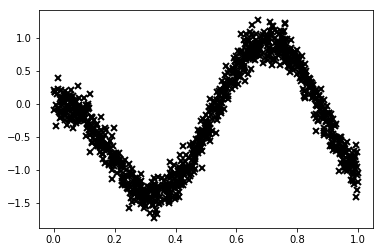

In [139]:
X = np.random.random((1000, 1))
Y_true = np.cos(X*9) + np.sin(X*2) - np.exp(X/23)
Y = Y_true + np.random.normal(loc=0, scale=0.15, size=(1000, 1))

_ = plt.plot(X, Y, 'kx', mew=2)

In [140]:
Xtr = torch.from_numpy(X[:900])
Ytr = torch.from_numpy(Y[:900])
Xts = torch.from_numpy(X[900:])
Yts = torch.from_numpy(Y[900:])

## Choose a kernel

Currently very few kernels are implemented in Falkon, although this will likely change in the future.
In this notebook we will use the **Gaussian kernel** which is one of the most commonly used kernel functions since it imposes a smooth prior over the learned function approximation.

The Gaussian kernel is parametrized by the lengthscale: a scalar parameter which should depend on the distance between data-points. We will later find the best value for this parameter with cross-validation, but for now we set it to an initial guess.

In [141]:
sigma = 0.1
k = kernels.GaussianKernel(sigma)

## Create the model
Here we have to decide the model's parameters. Other than the kernel there are two very important parameters:

`M` determines the number of centers for the Nystroem approximation. A higher value of M will produce a better approximation of the full kernel-ridge regression at the expense of more computations.
The choice of `M` will then depend on the complexity of the problem and on the amount of time and memory available. Very complex problems will typically achieve better performance with more centers. 
For our toy dataset we can use very few centers without seeing any performance degradation.

`penalty` controls the amount of penalization to be applied to the simple least-squares problem. Higher values of `penalty` can reduce overfitting. The best value can be determined with cross-validation.

We also define the error function to be the mean-squared error. This is only used for reporting the error at each iteration and does not modify the algorithm in any way.

In [142]:
def mean_squared_error(true, pred):
    return np.mean((true.numpy() - pred.numpy())**2)

model = Falkon(
    M=50,
    penalty=1e-5,
    kernel=k,
    seed=19,
    error_fn=mean_squared_error
)

## Fit the model
Calling the `fit` method on the model performs parameter estimation. Given we have very little data this will be extremely fast even without having a GPU.

In [146]:
model.fit(Xtr, Ytr)

MainProcess.MainThread::[Calcuating Preconditioner of size 50]
MainProcess.MainThread::[Calcuating Preconditioner of size 50] complete in 0.002s
MainProcess.MainThread::[Computing Falkon iterations]
Iteration   1 - Elapsed 0.0s - training error: 0.5752
Iteration   2 - Elapsed 0.0s - training error: 0.5294
Iteration   3 - Elapsed 0.0s - training error: 0.4652
Iteration   4 - Elapsed 0.1s - training error: 0.2624
Iteration   5 - Elapsed 0.1s - training error: 0.1175
Iteration   6 - Elapsed 0.1s - training error: 0.0936
Iteration   7 - Elapsed 0.1s - training error: 0.0891
Iteration   8 - Elapsed 0.1s - training error: 0.0829
Iteration   9 - Elapsed 0.1s - training error: 0.0590
Iteration  10 - Elapsed 0.2s - training error: 0.0365
Iteration  11 - Elapsed 0.2s - training error: 0.0323
Iteration  12 - Elapsed 0.2s - training error: 0.0315
Iteration  13 - Elapsed 0.2s - training error: 0.0308
Iteration  14 - Elapsed 0.2s - training error: 0.0278
Iteration  15 - Elapsed 0.2s - training error

Falkon(M=50,
       center_selection=<falkon.center_selection.UniformSel object at 0x7f7bac084550>,
       chol_block_size=256, chol_force_in_core=False, chol_force_ooc=False,
       chol_tile_size='auto', compute_arch_speed=False,
       cpu_preconditioner=False, error_every=1,
       error_fn=<function mean_squared_error at 0x7f7badda1a60>,
       final_type=torch.float64, gpu_use_processes=False,
       inter_t...nel(sigma=0.1),
       max_cpu_mem=inf, max_gpu_mem=inf, maxiter=20, mb_size=128,
       opt_tolerance=1e-07,
       optim=<falkon.optim.conjgrad.FalkonConjugateGradient object at 0x7f7bac084630>,
       pc_epsilon={torch.float32: 1e-05, torch.float64: 1e-13}, penalty=1e-05,
       precond=<falkon.precond.cholprec.FalkonPreconditioner object at 0x7f7bac074160>,
       seed=19, step_size='1/sqrt', use_cpu=True)

## Make predictions

By calling the `predict` method on the model we can obtain predictions for the test data.
We calculate the MSE on the test data to be similar to that on the training data, which is a good indication that we have obtained a good fit. 
Plotting the predictions reveals that indeed we have managed to smooth out the noise in the original dataset

In [147]:
preds = model.predict(Xts)
test_err = mean_squared_error(Yts, preds)
print("Test MSE: %.4f" % (test_err))

Test MSE: 0.0195


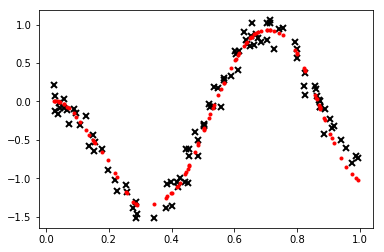

In [148]:
fig, ax = plt.subplots()
ax.plot(Xts, Yts, 'kx', mew=2)
_ = ax.plot(Xts, preds, 'r.')

## Cross validation
We can use cross-validation to determine the best parameters. Here we use it to estimate a good lengthscale parameter for our Gaussian kernel.

We find that our initial choice of sigma was the best among the combinations tested.

In [149]:
from sklearn import model_selection
splitter = model_selection.KFold(5)

sigma_candidates = [0.01, 0.1, 1.0, 10]
errors = []

for sigma in sigma_candidates:
    k = kernels.GaussianKernel(sigma)
    model = Falkon(
        M=50,
        penalty=1e-5,
        kernel=k,
        seed=18
    )
    
    iter_errors = []
    for tr_idx, val_idx in splitter.split(Xtr):
        model.fit(Xtr[tr_idx], Ytr[tr_idx])
        err = mean_squared_error(Ytr[val_idx], model.predict(Xtr[val_idx]))
        iter_errors.append(err)
    errors.append(np.mean(iter_errors))

MainProcess.MainThread::[Calcuating Preconditioner of size 50]
MainProcess.MainThread::[Calcuating Preconditioner of size 50] complete in 0.001s
MainProcess.MainThread::[Computing Falkon iterations]
MainProcess.MainThread::[Computing Falkon iterations] complete in 0.312s
MainProcess.MainThread::[Calcuating Preconditioner of size 50]
MainProcess.MainThread::[Calcuating Preconditioner of size 50] complete in 0.001s
MainProcess.MainThread::[Computing Falkon iterations]
MainProcess.MainThread::[Computing Falkon iterations] complete in 0.296s
MainProcess.MainThread::[Calcuating Preconditioner of size 50]
MainProcess.MainThread::[Calcuating Preconditioner of size 50] complete in 0.001s
MainProcess.MainThread::[Computing Falkon iterations]
MainProcess.MainThread::[Computing Falkon iterations] complete in 0.302s
MainProcess.MainThread::[Calcuating Preconditioner of size 50]
MainProcess.MainThread::[Calcuating Preconditioner of size 50] complete in 0.001s
MainProcess.MainThread::[Computing Falk

In [151]:
for s, e in zip(sigma_candidates, errors):
    print("Sigma %f - MSE %f" % (s, e))

Sigma 0.010000 - MSE 0.198599
Sigma 0.100000 - MSE 0.022833
Sigma 1.000000 - MSE 0.091269
Sigma 10.000000 - MSE 0.504611
